In [54]:
import os
import glob

import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

In [27]:
import sys
import platform
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.SMAP as hSMAP
importlib.reload(hSMAP);

In [12]:
def list_nc_files(base_dir):
    # This function will return a list of all .nc files in the directory and its subdirectories
    nc_files = []
    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        # Filter for .nc files
        for file in files:
            if file.endswith(".nc4"):
                full_path = os.path.join(root, file)
                nc_files.append(full_path)
    
    nc_files.sort() 
    return nc_files

# Base directory containing the 'L1_V21' folder
base_dir = "/Users/hyunglokkim/cpuserver_data/CYGNSS/L1_V21"

# Call the function and get the list of .nc files
nc_file_list = list_nc_files(base_dir)

# Print out the list of files
#for file in nc_file_list:
#    print(file)

In [17]:
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

In [30]:
longitude, latitude = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')

In [ ]:
# Compute the differences between consecutive latitudes and longitudes
lat_diff = np.diff(latitude, axis=0)
lon_diff = np.diff(longitude, axis=1)

# Define the bins for latitude and longitude
lat_bins = np.cumsum(np.concatenate(([0], np.abs(lat_diff.flatten()))))
lon_bins = np.cumsum(np.concatenate(([0], np.abs(lon_diff.flatten()))))

# Process the first 10 netCDF files from nc_file_list
for nc_file_path in nc_file_list[:100]:
    # Open the netCDF file
    with Dataset(nc_file_path, 'r') as ds:
        # Read sp_lat and sp_lon variables
        sp_lat = ds.variables['sp_lat'][:].flatten()
        sp_lon = ds.variables['sp_lon'][:].flatten() - 180

        # Remove NaN values
        valid_indices = ~np.isnan(sp_lat) & ~np.isnan(sp_lon)
        sp_lat = sp_lat[valid_indices]
        sp_lon = sp_lon[valid_indices]

        # Compute histogram of sp_lat and sp_lon coordinates
        hist, _, _ = np.histogram2d(sp_lat, sp_lon, bins=(lat_bins, lon_bins))

        # Add the histogram counts to the grid_count array
        grid_count += hist


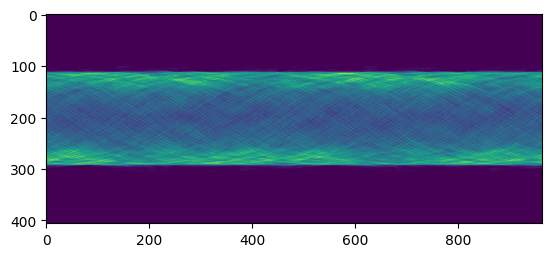

In [198]:
plt.imshow(grid_count)

In [199]:
# Initialize grid count array
grid_count = np.zeros_like(latitude)

# Loop through first 10 netCDF files
for nc_file in nc_file_list[:10]:
    # Open netCDF file
    with Dataset(nc_file, 'r') as ds:
        # Read sp_lat and sp_lon
        sp_lat = ds.variables['sp_lat'][:].flatten()
        sp_lon = ds.variables['sp_lon'][:].flatten() - 180

        # Remove NaN values
        valid_indices = ~np.isnan(sp_lat) & ~np.isnan(sp_lon)
        sp_lat = sp_lat[valid_indices]
        sp_lon = sp_lon[valid_indices]
        
        # Check if there are any valid points
        if len(sp_lat) == 0:
            continue
        
        # Print out sp_lat and sp_lon for debugging
        print("sp_lat:", sp_lat)
        print("sp_lon:", sp_lon)
        
        # Create KDTree for latitude and longitude
        kdtree = cKDTree(list(zip(latitude.flatten(), longitude.flatten())))

        # Loop through sp_lat and sp_lon pairs
        for lat, lon in zip(sp_lat, sp_lon):
            # Find nearest grid cell
            dist, index = kdtree.query([lat, lon])

            # Increment corresponding grid cell in grid count array
            index = np.unravel_index(index, grid_count.shape)
            grid_count[index] += 1

sp_lat: [30.122819900512695 32.998023986816406 24.18456268310547 ...
 -1.00910222530365 -8.34675121307373 3.797614097595215]
sp_lon: [4.4560394287109375 7.7821807861328125 2.5626983642578125 ...
 47.82887268066406 43.90809631347656 51.48912048339844]


/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_44702/3945408258.py:31: UserWarning: Warning: converting a masked element to nan.
  dist, index = kdtree.query([lat, lon])


ValueError: 'x' must be finite, check for nan or inf values

In [132]:
sp_lat

NameError: name 'sp_lat' is not defined